# Introduction & Background

Housing in Singapore has never been a cheap affair, [with CBRE ranking Singapore as the country with the 3rd highest average property price of US$915,601 in 2020](https://www.cbreresidential.com/uk/sites/uk-residential/files/CBRE-Global%20Living_2020_Final.pdf). Is that intimidating figure representative of the actual situation in Singapore? In this notebook, we investigate [HDB flats' resale prices](https://data.gov.sg/dataset/resale-flat-prices) from 2017-01-01 to 2021-01-31. For the uninitiated, HDB flats are built primarily to provide affordable public housing.

Some questions we may want to answer are:
- how stable have prices been? did the covid situation affect the housing market?
- factors affecting price? (easy to pin everything down to location. but other factors like house, upcoming plans also affect)
- are all houses equal i.e same size?
- given past data, can we reliably predict on new unseen data

## Table of contents
1. EDA
2. Supervised
3. Unsupervised

# Exploratory Data Analysis

First, let's take a quick glance at our data.

In [1]:
import pandas as pd
pd.options.display.float_format = '{:.2f}'.format # Formatting for floats

data = pd.read_csv("resale-flat-prices-based-on-registration-date-from-jan-2017-onwards.csv")

summary = data.describe(include='all')
summary

month      town flat_type  block     street_name storey_range  \
count     90123     90123     90123  90123           90123        90123   
unique       49        26         7   2484             551           17   
top     2018-07  SENGKANG    4 ROOM      2  YISHUN RING RD     04 TO 06   
freq       2539      7372     37302    307            1350        20957   
mean        NaN       NaN       NaN    NaN             NaN          NaN   
std         NaN       NaN       NaN    NaN             NaN          NaN   
min         NaN       NaN       NaN    NaN             NaN          NaN   
25%         NaN       NaN       NaN    NaN             NaN          NaN   
50%         NaN       NaN       NaN    NaN             NaN          NaN   
75%         NaN       NaN       NaN    NaN             NaN          NaN   
max         NaN       NaN       NaN    NaN             NaN          NaN   

        floor_area_sqm flat_model  lease_commence_date     remaining_lease  \
count         90123.00      90123             90123.00               90123   
unique             NaN         20                  NaN                 632   
top                NaN    Model A                  NaN  94 years 09 months   
freq               NaN      29432                  NaN                 713   
mean             97.76        NaN              1994.38                 NaN   
std              24.28        NaN                13.02                 NaN   
min              31.00        NaN              1966.00                 NaN   
25%              82.00        NaN              1984.00                 NaN   
50%              95.00        NaN              1995.00                 NaN   
75%             113.00        NaN              2003.00                 NaN   
max             249.00        NaN              2019.00                 NaN   

        resale_price  
count       90123.00  
unique           NaN  
top              NaN  
freq             NaN  
mean       443746.19  
std        154381.36  
min        140000.00  
25%        332000.00  
50%        413800.00  
75%        520000.00  
max       1258000.00

`describe()` will obtain the most frequent value for categorical variables and descriptive statistics for continuous variables. 

It seems that the town with the most number of transactions is Sengkang and the most common flat type is a 4-room flat. On average, a flat is 97.76 square metres large, costs S$443,746 and is about 27 years old (calculated from `lease_commence_date` since it is a float. `remaining_lease` is in string format and is thus unreliable).

We can also go one step further and analyse several variables individually.

### Month

In [2]:
import plotly.express as px

month = data.groupby('month').agg(['count', 'mean'])
month = month.loc[:, [('resale_price', 'count'),
                      ('resale_price', 'mean')]]
month.columns = ['number of transactions', 'mean resale price']
month.reset_index(inplace=True)

fig = px.line(month, x="month", y="number of transactions", 
              title='Monthly transactions from Jan-2017 to Jan-2021',
              labels={'month': 'Month',
                      'number of transactions': 'Number of transactions',
                      'mean resale price': 'Mean resale price in S$'},
              hover_data={"mean resale price":":.2f", # to format hover data
                          "month": "|%b %Y"})
fig.show()

In [3]:
fig = px.line(month, x="month", y="mean resale price", 
              title='Mean monthly resale price from Jan-2017 to Jan-2021',
              labels={'month': 'Month',
                      'number of transactions': 'Number of transactions',
                      'mean resale price': 'Mean resale price in S$'},
              hover_data={"number of transactions":":.d", # to format hover data
                          "month": "|%b %Y"})
fig.update_layout(yaxis_tickformat ='.2f') # to format resale_price with 2 dp 
fig.show()

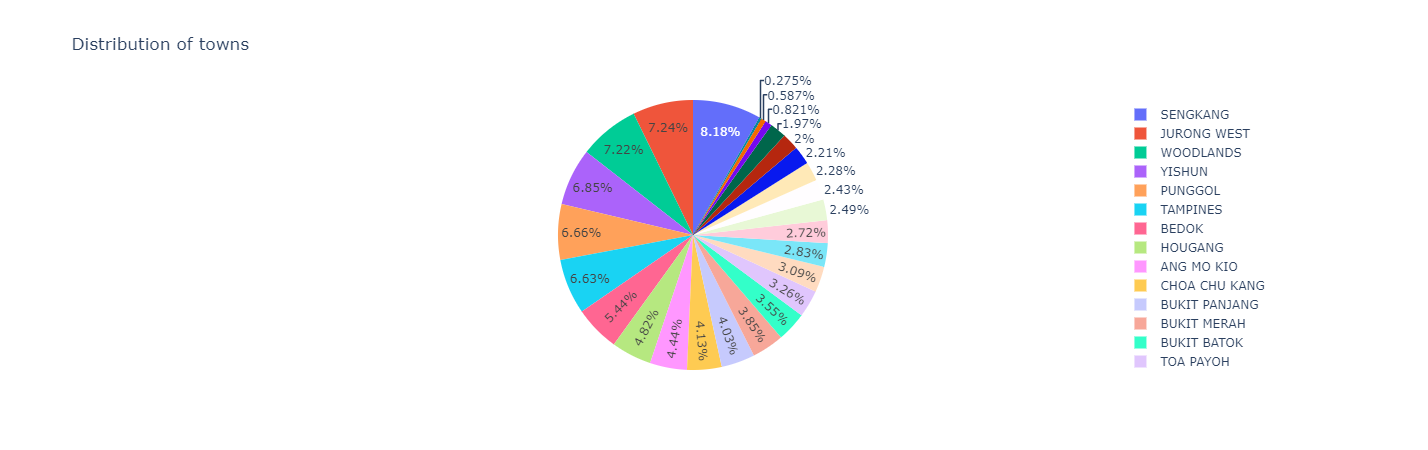

In [5]:
#%% groupby towns 

towns = data.groupby('town')

# transactions per town 
towns_transac = towns['month'].count().reset_index()
towns_transac.rename(columns={'month': 'number of transactions'}, inplace=True)
fig = px.pie(towns_transac, values='number of transactions', names='town', title='Distribution of towns',
             labels={'town': 'Town',
                     'number of transactions':'Number of transactions'})
fig.show()

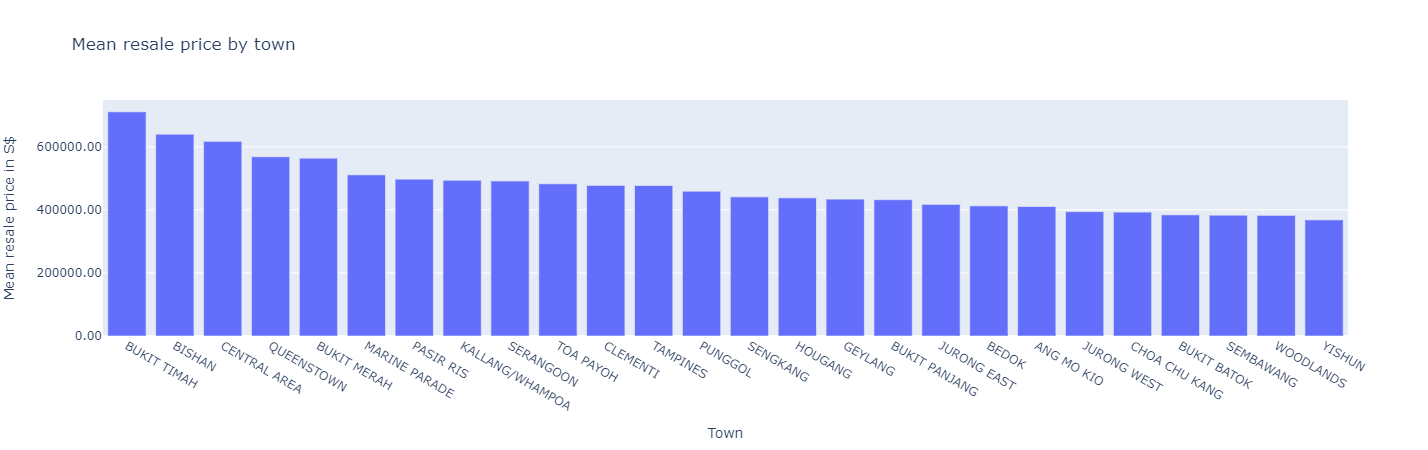

In [6]:
# mean price per town
towns_meanprice = towns['resale_price'].mean().reset_index().sort_values('resale_price', ascending=False)
towns_meanprice = towns_meanprice.merge(towns_transac, on='town') # to also see number of transactions for each town 
fig = px.bar(towns_meanprice, x='town', y='resale_price',
             title="Mean resale price by town",
             labels={'town': 'Town',
                     'resale_price':'Mean resale price in S$',
                     'number of transactions': 'Number of transactions'},
             hover_data=['number of transactions'])
fig.update_layout(yaxis_tickformat ='.2f') # to format resale_price with no dp 
fig.show()

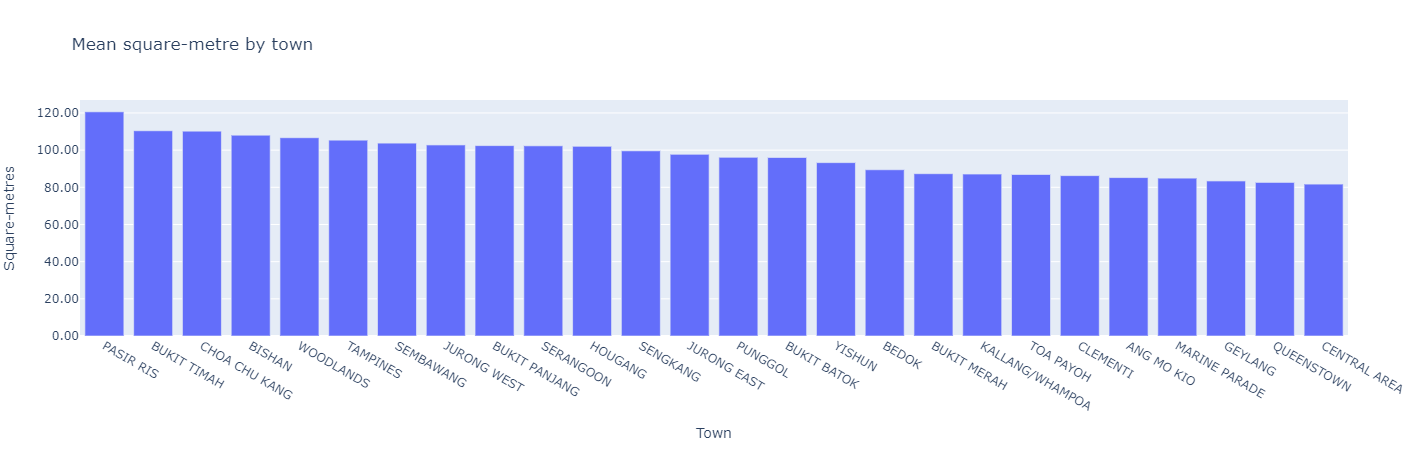

In [7]:
# mean sqm per town 
# pasir ris 7th most exp, but largest sqm on average by quite a distance 
towns_meansqm = towns['floor_area_sqm'].mean().reset_index().sort_values('floor_area_sqm', ascending=False)
fig = px.bar(towns_meansqm, x='town', y='floor_area_sqm',
             title="Mean square-metre by town",
             labels={'town': 'Town',
                     'floor_area_sqm':'Square-metres'})
fig.update_layout(yaxis_tickformat ='.2f') # to format sqm with 2 dp 
fig.show()


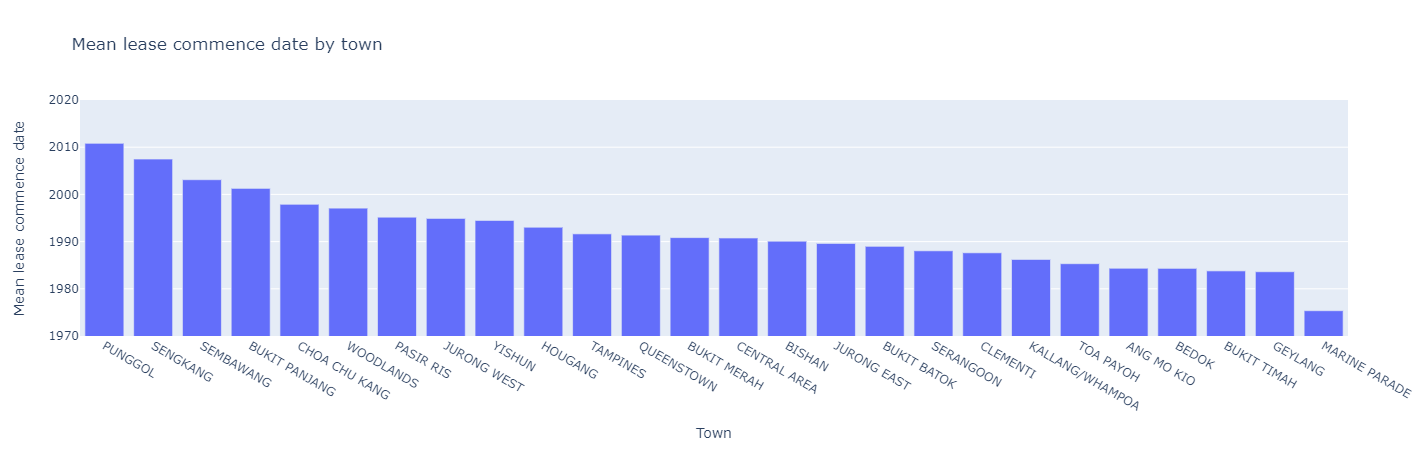

In [8]:
# mean lease date per town
towns_lease = towns['lease_commence_date'].mean().reset_index().sort_values('lease_commence_date', ascending=False)
towns_lease = towns_lease.merge(towns_transac, on='town') # to also see number of transactions for each town 
fig = px.bar(towns_lease, x='town', y='lease_commence_date',
             title="Mean lease commence date by town",
             labels={'town': 'Town',
                     'lease_commence_date':'Mean lease commence date',
                     'number of transactions': 'Number of transactions'},
             hover_data=['number of transactions'])
fig.update_layout(yaxis_tickformat ='.0f') # to format resale_price with no dp 
fig.update_yaxes(range=[1970, 2020]) # manually set y-axis range otherwise it would be from 0 to 2020
fig.show()

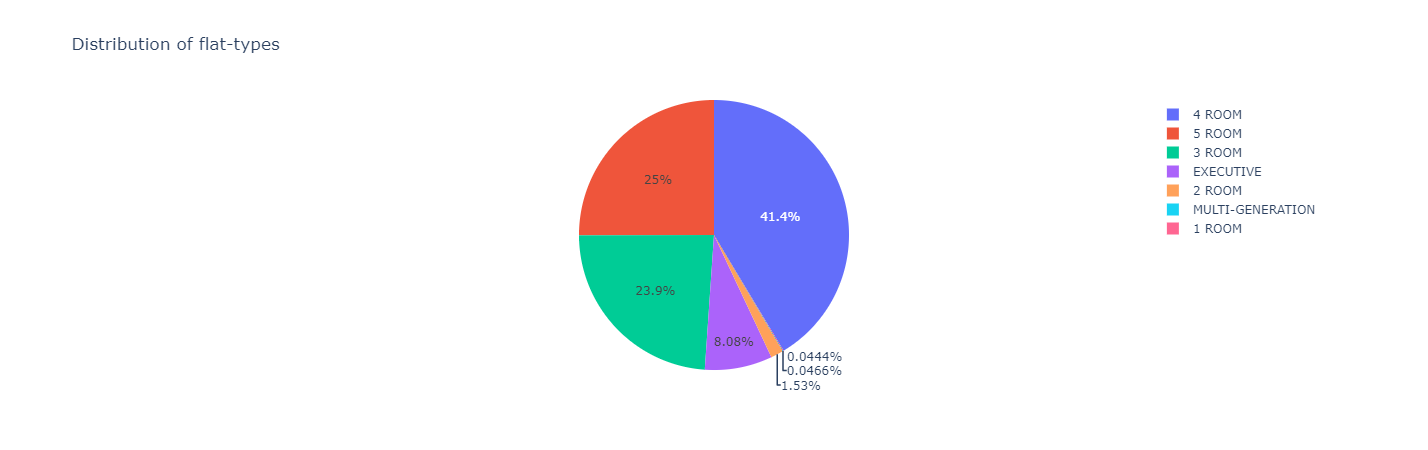

In [9]:
#%% groupby flat type 

flat = data.groupby('flat_type')

flat_transac = flat['month'].count().reset_index()
flat_transac.rename(columns={'month': 'number of transactions'}, inplace=True)
fig = px.pie(flat_transac, values='number of transactions', names='flat_type', title='Distribution of flat-types',
             labels={'flat_type':'Flat type',
                     'number of transactions': 'Number of transactions'})
fig.show()

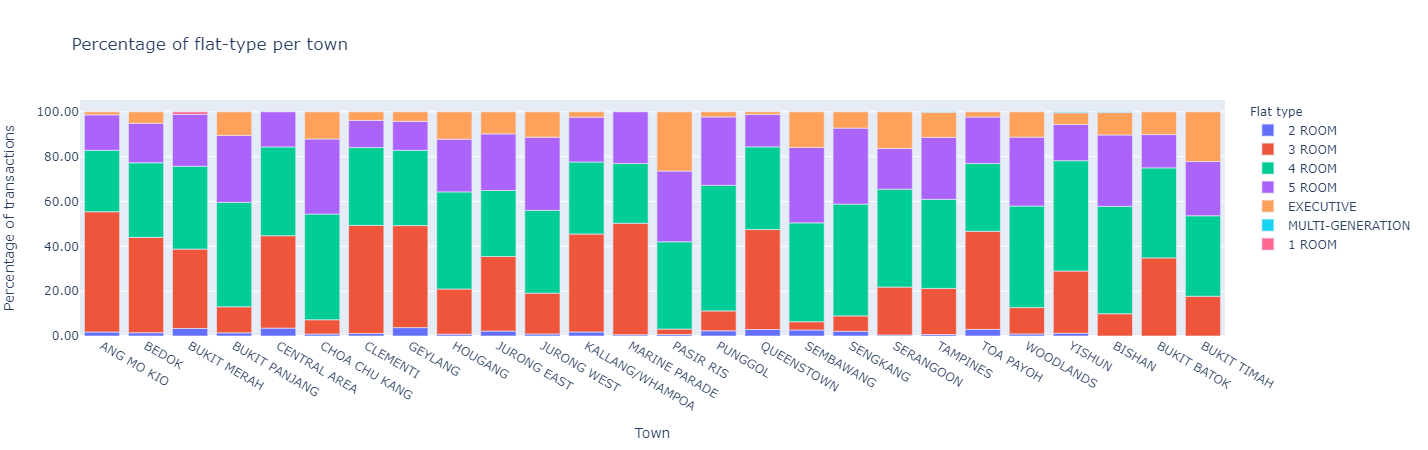

In [10]:
#%% groupby town, flat type
# flat type per town
towns = data.groupby(['town','flat_type'])
towns_transac = towns['month'].count().reset_index()
towns_transac.rename(columns={'month': 'number of transactions'}, inplace=True)

towns_temp = towns_transac.groupby('town').sum().reset_index() # must groupby again to get number of transactions for each town 
towns_temp.rename(columns={'number of transactions': 'total transactions'}, inplace=True)
towns_transac = towns_transac.merge(towns_temp, on='town', how='inner')
towns_transac['percentage of transactions'] = towns_transac['number of transactions'] / towns_transac['total transactions'] * 100 

fig = px.bar(towns_transac, x="town", y="percentage of transactions", color="flat_type", title="Percentage of flat-type per town",
             labels={'flat_type':'Flat type',
                     'percentage of transactions': 'Percentage of transactions',
                     'town': 'Town',
                     'number of transactions': 'Number of transactions'},
             hover_data=['number of transactions'],
             hover_name="flat_type")
fig.update_layout(yaxis_tickformat ='.2f')
fig.show()

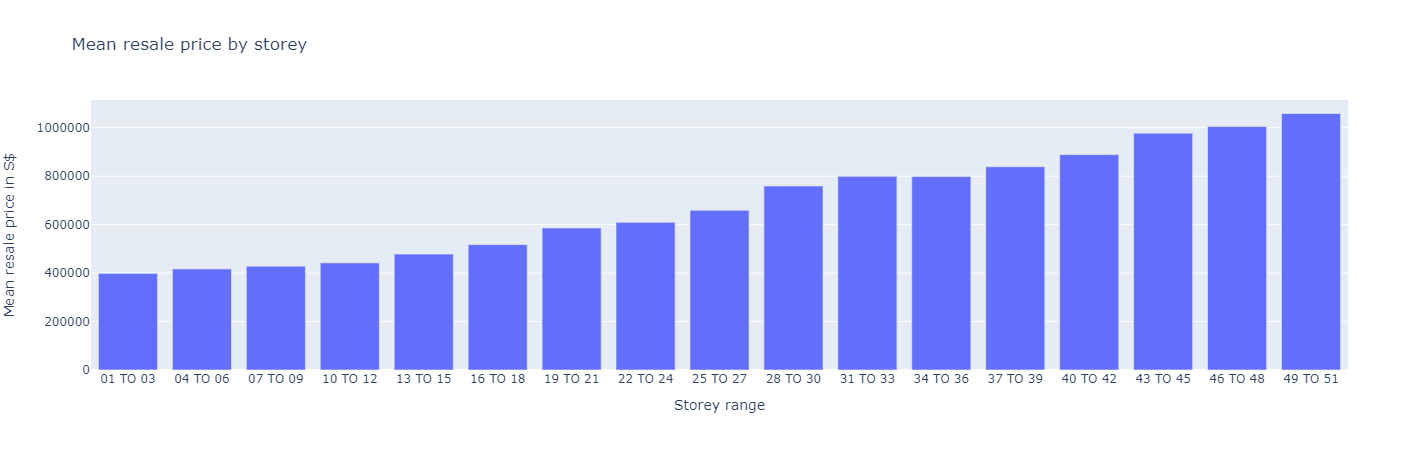

In [11]:
#%% groupby storey range 

storey = data.groupby('storey_range').agg(['count', 'mean'])
storey = storey.loc[:, [('floor_area_sqm', 'count'),
                        ('resale_price', 'mean')]].reset_index()
storey.columns = ['storey_range', 'number_of_transactions', 'resale_price']

fig = px.bar(storey, x='storey_range', y='resale_price',
             title="Mean resale price by storey",
             labels={'storey_range': 'Storey range',
                     'resale_price':'Mean resale price in S$',
                     'number_of_transactions': 'Number of transactions'},
             hover_data=['number_of_transactions'])
fig.update_layout(yaxis_tickformat ='.0f') # to format resale_price with no dp 
fig.show()

# parents gen used to avoid 4 and buy 8, now it just seems like the higher it is the more exp it is 
# makes sense because i live on 6th floor and find myself being able to hear people talking loudly on the first floor 
# also, can see that number of transactions rapidly decreases after to less than 1000 after '22 TO '24'.
# could be due to older flats only up to 20 storeys, so we dont have a lot of data for the higher floors 


In [12]:
#%% groupby street name

street = data.groupby(['town', 'street_name']).agg(['count', 'mean'])
street = street.loc[:, [('floor_area_sqm', 'count'),
                        ('floor_area_sqm', 'mean'),
                        ('lease_commence_date', 'mean'),
                        ('resale_price', 'mean')]].reset_index() # only select columns we want 
street.columns = ['Town', 'Street', 'Number of transactions', 
                  'Mean floor area', 'Mean lease commence date', 
                  'Mean resale price'] # rename multiIndex to singleIndex

# amk ave 10 and 3, near mrt, town centre. amenities? 
# bedok reservoir road, near mrt and famous prawn noodle 
street

Town             Street  Number of transactions  Mean floor area  \
0    ANG MO KIO   ANG MO KIO AVE 1                     426        84.842723   
1    ANG MO KIO  ANG MO KIO AVE 10                     936        82.025641   
2    ANG MO KIO   ANG MO KIO AVE 2                      12       135.000000   
3    ANG MO KIO   ANG MO KIO AVE 3                     862        81.410673   
4    ANG MO KIO   ANG MO KIO AVE 4                     486        83.802469   
..          ...                ...                     ...              ...   
546      YISHUN       YISHUN ST 51                     138        97.304348   
547      YISHUN       YISHUN ST 61                     340       105.714706   
548      YISHUN       YISHUN ST 71                     199        88.085427   
549      YISHUN       YISHUN ST 72                     220        85.295455   
550      YISHUN       YISHUN ST 81                     310       108.345161   

     Mean lease commence date  Mean resale price  
0                 1990.140845      444109.117371  
1                 1979.824786      344307.130342  
2                 1982.000000      766622.000000  
3                 1978.606729      358831.350348  
4                 1981.794239      365092.041152  
..                        ...                ...  
546               2016.000000      444079.289855  
547               1987.702941      399030.176471  
548               1986.517588      324782.231156  
549               1985.022727      342874.909091  
550               1987.748387      421644.838710  

[551 rows x 6 columns]

places like sembawang and pasir ris seem to be good deals, but then we realise they are damn far from city centre

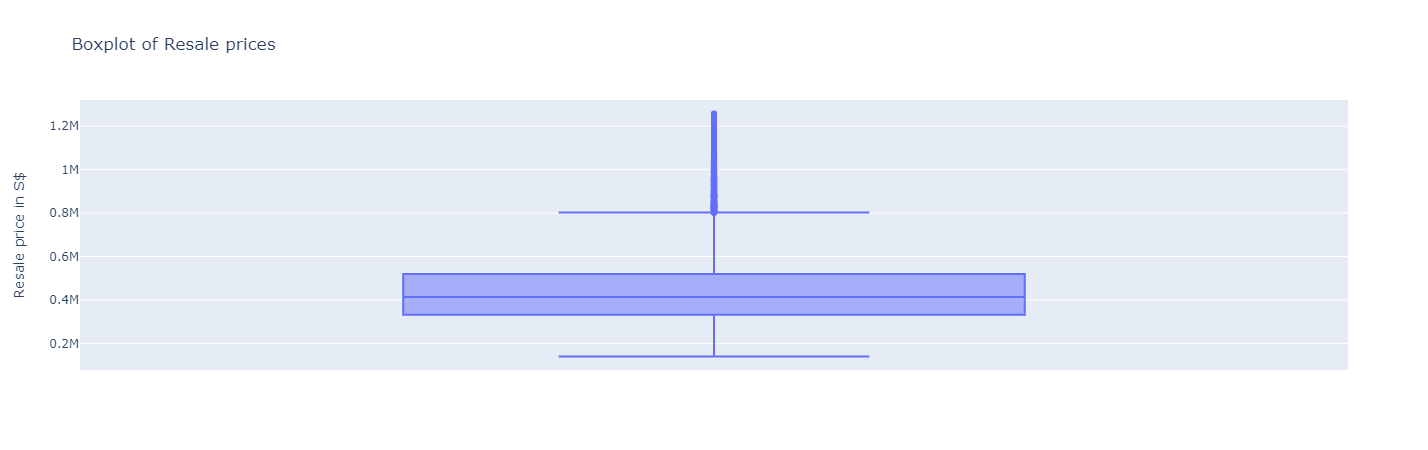

In [16]:
#%% boxplot of resale prices
# entire country

fig = px.box(data, y='resale_price', title="Boxplot of Resale prices",
             labels={'resale_price': 'Resale price in S$'})
fig.show()

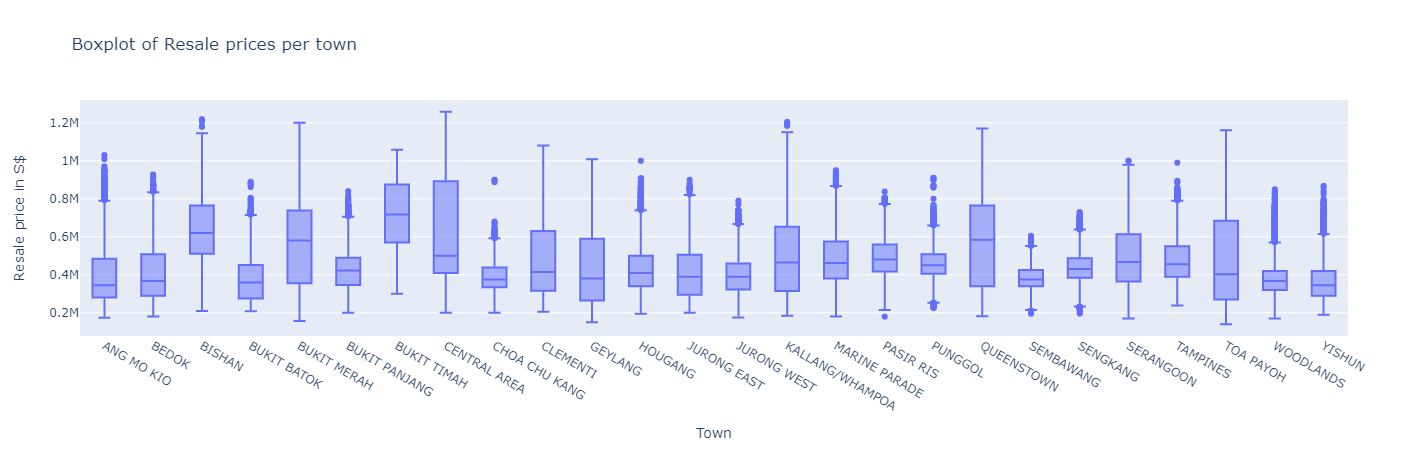

In [17]:
# by town

fig = px.box(data, x='town', y='resale_price', 
             title="Boxplot of Resale prices per town",
             labels={'resale_price': 'Resale price in S$',
                     'town': 'Town'})
fig.show()

seems like a lot of outliers (since so many outside IQR) but in the news we can see that this is a rising trend (find news articles of expensive HDBs)

# have some overall summary of EDA before proceeding

some thoughts:
- is it true that towns further from city centre are cheaper (seems like it, if we see top 3 cheapest and most exp)
- did covid affect demand (yes, sharp drop then increase to levels even higer than pre covid (maybe due to ppl wanting to move out quicker after CB period?). this sharp increase might have led to increase in price (demand for flats increase, supply remain constant or even drop since workers were in low supply))
- seasonal effects? (yes, at least for 2017, 2018 and 2019. jan always seem to have less transactions)
- punggol and sengkang flats are quite new, maybe thats why they took up a lot of transactions
- pasir ris on avg have significantly larger flats and their prices are not the highest, probably due to its proximity from city centre

debatable to include 2020 data due to covid but its gonna be a new normal moving forward

**maybe should add another binary variable (before covid, after covid)?**

are extreme prices really outlier? they are becoming more common as reported by the news

add in notebook that its more of an art than sci
include links to controversial parts such as standardising of categorical

both gave same results but elasticnetCV is much faster, probably due to warm starts https://github.com/scikit-learn/scikit-learn/issues/11659

another one saying that there is likely no formal way to show what is better, if possible should just try out different combinations
https://datascience.stackexchange.com/questions/37362/when-should-one-use-l1-l2-regularization-instead-of-dropout-layer-given-that-b